# Supporting Aperio SVS Format (since v21.10.01)

As of **v21.10.01**, **cuCIM** supports Aperio SVS Format(.svs).

## Install prerequisites

In [1]:
!pip install cucim

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/home/gbae/.pyenv/versions/3.8.10/envs/cucim-3.8/bin/python3.8 -m pip install --upgrade pip' command.


In [2]:
!pip install wget matplotlib

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/home/gbae/.pyenv/versions/3.8.10/envs/cucim-3.8/bin/python3.8 -m pip install --upgrade pip' command.


## Download Datasets

We can download sample SVS files from [OpenSlide Test Data](https://openslide.cs.cmu.edu/download/openslide-testdata/index.html) which is available under [CC0-1.0](https://creativecommons.org/publicdomain/zero/1.0/) LICENSE.

In [3]:
DATA_PATH_LIST = []

import json
import wget
from pathlib import Path

data_url = "https://openslide.cs.cmu.edu/download/openslide-testdata"
if not Path("index.json").exists():
    wget.download(f"{data_url}/index.json")

with open("index.json") as fp:
    data_index = json.load(fp)

Path("Aperio").mkdir(parents=True, exist_ok=True)
for file_path in data_index:
    if file_path.startswith("Aperio/"):
        DATA_PATH_LIST.append(file_path)
        if not Path(file_path).exists():
            file_info = data_index[file_path]
            print(f"# Downloading {file_path} ({file_info['description']}) ...")
            wget.download(f"{data_url}/{file_path}", out=file_path)
            print()

# Downloading Aperio/CMU-1-JP2K-33005.svs (Export of CMU-1.svs, brightfield, JPEG 2000, RGB) ...
100% [......................................................................] 132565343 / 132565343
# Downloading Aperio/CMU-1-Small-Region.svs (Exported region from CMU-1.svs, brightfield, JPEG, small enough to have a single pyramid level) ...
100% [..........................................................................] 1938955 / 1938955
# Downloading Aperio/CMU-1.svs (Brightfield, JPEG) ...
100% [......................................................................] 177552579 / 177552579
# Downloading Aperio/CMU-2.svs (Brightfield, JPEG) ...
100% [......................................................................] 390750635 / 390750635
# Downloading Aperio/CMU-3.svs (Brightfield, JPEG) ...
100% [......................................................................] 253815723 / 253815723
# Downloading Aperio/JP2K-33003-1.svs (Aorta tissue, brightfield, JPEG 2000, YCbCr) ...
100% 

## Accessing Metadata

Aperio SVS-specific metadata is available at `aperio` of `metadata` field of the `CuImage` object.

In [4]:
from cucim import CuImage
import pprint

pp = pprint.PrettyPrinter(indent=2, compact=True)

for file_name in DATA_PATH_LIST:
    img = CuImage(file_name)
    print("#", file_name)
    metadata = img.metadata
    pp.pprint(img.metadata)

# Aperio/CMU-1-JP2K-33005.svs
{ 'aperio': { 'AppMag': '20',
              'Date': '12/29/09',
              'Filename': 'CMU-1',
              'Filtered': '5',
              'Focus Offset': '0.000000',
              'Header': 'Aperio Image Library v11.2.1 \r\n'
                        '46000x32914 [0,0 46000x32893] (240x240) J2K/KDU '
                        'Q=30;CMU-1;Aperio Image Library v10.0.51\r\n'
                        '46920x33014 [0,100 46000x32914] (256x256) JPEG/RGB '
                        'Q=30',
              'ImageID': '1004486',
              'Left': '25.691574',
              'LineAreaXOffset': '0.019265',
              'LineAreaYOffset': '-0.000313',
              'LineCameraSkew': '-0.000424',
              'MPP': '0.4990',
              'OriginalHeight': '32914',
              'OriginalWidth': '46920',
              'Originalheight': '33014',
              'Parmset': 'USM Filter',
              'ScanScope ID': 'CPAPERIOCS',
              'StripeWidth': '2040',
  

`associated_images` field has a set of available associated images such as 'label', 'macro', and 'thumbnail' images.

In [5]:
img.associated_images

{'label', 'macro', 'thumbnail'}

## Visualizing Sample SVS Images

/tmp/ipykernel_8881/1677916248.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(width / dpi, height / dpi))


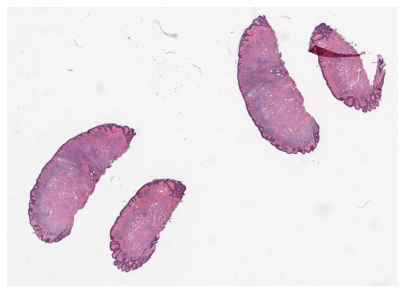

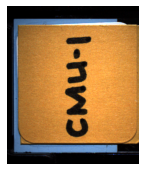

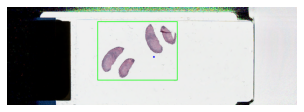

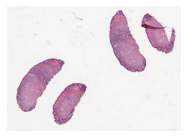

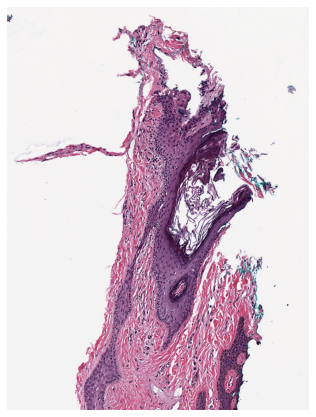

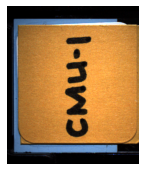

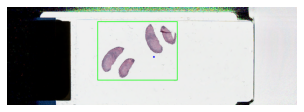

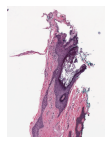

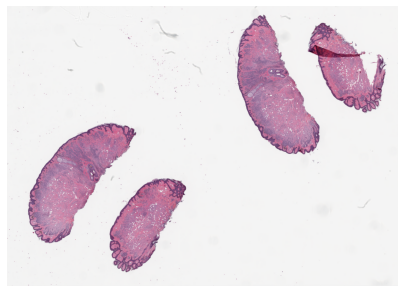

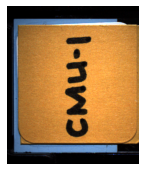

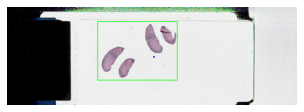

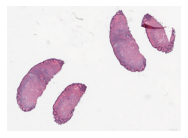

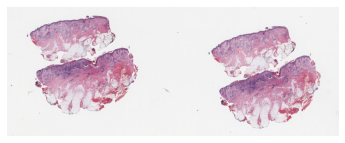

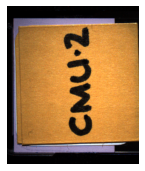

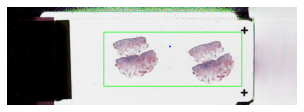

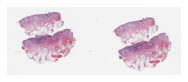

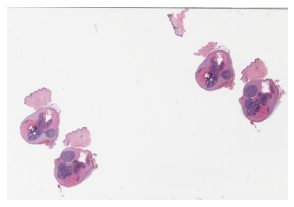

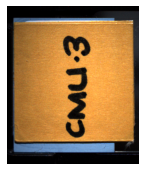

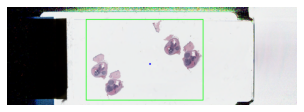

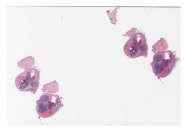

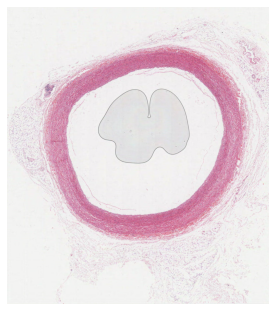

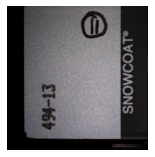

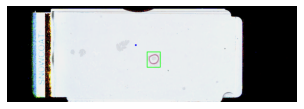

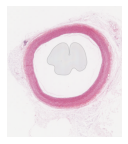

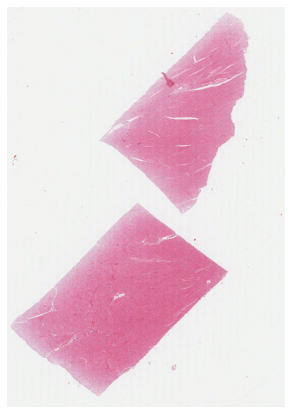

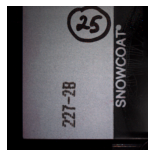

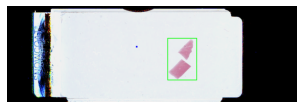

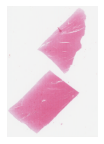

In [45]:
from matplotlib import pyplot as plt


def visualize(image, downsample=1):
    dpi = 80.0 * downsample
    height, width, _ = image.shape
    plt.figure(figsize=(width / dpi, height / dpi))
    plt.axis("off")
    plt.imshow(image)


plt.close("all")

import numpy as np
from cucim import CuImage

for file_name in DATA_PATH_LIST:
    img = CuImage(file_name)
    metadata = img.metadata
    level_count = metadata["cucim"]["resolutions"]["level_count"]
    small_img = img.read_region(
        level=level_count - 1
    )  # read whole image at the lowest resolution level
    label_img = img.associated_image("label")
    macro_img = img.associated_image("macro")
    thumbnail_img = img.associated_image("thumbnail")
    visualize(np.asarray(small_img), 5)
    visualize(np.asarray(label_img), 2)
    visualize(np.asarray(macro_img), 3)
    visualize(np.asarray(thumbnail_img), 4)

## Experimental Results

Like the experiments in [Using Cache](https://nbviewer.org/github/rapidsai/cucim/blob/v21.10.00/notebooks/Using_Cache.ipynb), we have compared performance against OpenSlide.

For the cache memory size(capacity) setting, we have used a similar approach with rasterio (5% of available system memory).


### System Information

- OS: Ubuntu 18.04
- CPU: [Intel(R) Core(TM) i7-7800X CPU @ 3.50GHz](https://www.cpubenchmark.net/cpu.php?cpu=Intel+Core+i7-7800X+%40+3.50GHz&id=3037)
- Memory: 64GB (G-Skill DDR4 2133 16GB X 4)
- Storage
  - SATA SSD: [Samsung SSD 850 EVO 1TB](https://www.samsung.com/us/computing/memory-storage/solid-state-drives/ssd-850-evo-2-5-sata-iii-1tb-mz-75e1t0b-am/)
  
### Experiment Setup

Benchmarked loading Aperio SVS format with OpenSlide.
+ Use read_region() APIs to read all patches (256x256 or 240x240 each, depending on the tile size) of a whole slide image (.svs) at the largest resolution level on multithread/multiprocess environment.
    - Performed on three SVS files that use a different compression method
        * JPEG: [TUPAC-TR-488.svs](https://drive.google.com/drive/u/0/folders/0B--ztKW0d17XYlBqOXppQmw0M2M), 1.57GB, 92344x81017, tile size 240x240
        * JPEG2000 RGB: [CMU-1-JP2K-33005.svs](https://openslide.cs.cmu.edu/download/openslide-testdata/Aperio/), 126MB, 46000x32893, tile size 240x240
        * JPEG2000 YCbCr (4:2:2): [JP2K-33003-2.svs](https://openslide.cs.cmu.edu/download/openslide-testdata/Aperio/), 275MB, 32671x47076, tile size 256x256
+ Two different job configurations
    - **multithreading**: spread workload into multiple threads
    - **multiprocessing**: spread workload into multiple processes
+ One read/cache configurations for each job configuration
    - **unaligned/cache(per-process)**: Read patches with size of 240x240 or 256x256, starting from the (120, 120) or (128, 128). e.g., read the region (120, 120)-(359,359) then, read the region (360, 120)-(599,359), ...
    - Note that aligned case is where (240x240) or (256x256)-patch-reads start from (0, 0). OpenSlide's internal cache mechanism does not affect this case.
+ Took about 10 samples due to the time to conduct the experiment so there could have some variation in the results.
+ Note that this experiment doesn’t isolate the effect of system cache (page cache) that we excluded its effect on C++ API benchmark[discard_cache] so IO time itself could be short for both libraries.

### Unaligned Case (`per_process`, JPEG-compressed SVS file)

![image](https://user-images.githubusercontent.com/1928522/141350490-06fdd8cb-5be2-42e4-9774-c7b76fab6f9a.png)

### Unaligned Case (`per_process`, JPEG2000 RGB-compressed SVS file)

![image](https://user-images.githubusercontent.com/1928522/141093324-574b532e-ad42-4d61-8473-4c3e07e3feae.png)

### Unaligned Case (`per_process`, JPEG2000 YCbCr-compressed SVS file)

![image](https://user-images.githubusercontent.com/1928522/141093381-8ab0161d-1b17-4e80-a680-86abfbf2fa65.png)

The detailed data is available [here](https://docs.google.com/spreadsheets/d/15D1EqNI_E9x_S8i3kJLwBxMcEmwk8SafW0WryMrAm6A/).

## Appendix

### Experiment Code

Please see <https://github.com/rapidsai/cucim/blob/branch-21.12/experiments/Supporting_Aperio_SVS_Format/benchmark.py> to check out the code used for the experiment.
